In [1]:
import numpy as np
import pickle
import random

def generate_data():
    np.random.seed(0)
    random.seed(0)

    filename = "mars_maps_data.pkl"
    data = []
    W, H = 100, 100

    vals = [0, 1, 5, 10]

    print("Generating Mars terrain dataset...")

    for i in range(10):
        if i < 5:
            m_type = "Simple"
            probs = [0.10, 0.70, 0.15, 0.05]
        else:
            m_type = "Complex"
            probs = [0.20, 0.30, 0.20, 0.30]

        grid = np.random.choice(vals, size=(H, W), p=probs)
        problems = []

        for _ in range(50):
            while True:
                r = np.random.randint(0, H)
                if grid[r, 0] != 0:
                    start = (r, 0)
                    break

            while True:
                r = np.random.randint(0, H)
                if grid[r, W - 1] != 0:
                    goal = (r, W - 1)
                    break

            problems.append((start, goal))

        data.append({
            'map_id': i,
            'type': m_type,
            'grid': grid,
            'problems': problems
        })

        print(f"Map {i} ({m_type}) generated.")

    with open(filename, 'wb') as f:
        pickle.dump(data, f)

    print(f"\nDataset saved to {filename}")

if __name__ == "__main__":
    generate_data()

Generating Mars terrain dataset...
Map 0 (Simple) generated.
Map 1 (Simple) generated.
Map 2 (Simple) generated.
Map 3 (Simple) generated.
Map 4 (Simple) generated.
Map 5 (Complex) generated.
Map 6 (Complex) generated.
Map 7 (Complex) generated.
Map 8 (Complex) generated.
Map 9 (Complex) generated.

Dataset saved to mars_maps_data.pkl


In [2]:
import heapq
import math

class Node:
    def __init__(self, r, c, g=float('inf'), h=0, parent=None):
        self.r = r
        self.c = c
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    def __lt__(self, other):
        if self.f == other.f:
            return self.h < other.h
        return self.f < other.f

class PQueue:
    def __init__(self):
        self.q = []

    def empty(self):
        return len(self.q) == 0

    def put(self, item):
        heapq.heappush(self.q, item)

    def get(self):
        return heapq.heappop(self.q)

def dist_euclidean(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

def dist_manhattan(p1, p2):
    return 3.0 * (abs(p1[0] - p2[0]) + abs(p1[1] - p2[1]))

def dist_aggressive(p1, p2):
    return 10.0 * dist_euclidean(p1, p2)

def neighbors(node, grid, w, h):
    r, c = node.r, node.c
    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < h and 0 <= nc < w and grid[nr, nc] != 0:
            yield (nr, nc)

def WAStar(grid, start, goal, h_func, eps=1.5):
    h, w = grid.shape
    openset = PQueue()
    g_score = {start: 0}
    came_from = {start: None}
    closed = set()
    expanded = 0

    start_node = Node(start[0], start[1], g=0, h=h_func(start, goal))
    start_node.f = eps * start_node.h
    openset.put(start_node)

    while not openset.empty():
        curr = openset.get()
        pos = (curr.r, curr.c)

        if pos in closed: continue
        if pos == goal:
            path = []
            while pos:
                path.append(pos)
                pos = came_from[pos]
            return path[::-1], expanded, g_score[goal]

        closed.add(pos)
        expanded += 1

        for nbr in neighbors(curr, grid, w, h):
            if nbr in closed: continue

            tentative_g = g_score[pos] + grid[nbr]
            if nbr not in g_score or tentative_g < g_score[nbr]:
                g_score[nbr] = tentative_g
                came_from[nbr] = pos
                hval = h_func(nbr, goal)
                n = Node(nbr[0], nbr[1], g=tentative_g, h=hval)
                n.f = tentative_g + eps * hval
                openset.put(n)

    return None, expanded, float('inf')

def MHAStar(grid, start, goal, heuristics, w1=1.5, w2=1.5):
    h, w = grid.shape
    queues = [PQueue() for _ in heuristics]
    g_score = {start: 0}
    came_from = {start: None}
    closed = set()
    expanded = 0

    for i, hf in enumerate(heuristics):
        weight = w1 if i == 0 else w2
        hval = hf(start, goal)
        n = Node(start[0], start[1], g=0, h=hval)
        n.f = weight * hval
        queues[i].put(n)

    while not queues[0].empty():
        for i, q in enumerate(queues):
            if q.empty(): continue

            curr = q.get()
            pos = (curr.r, curr.c)

            if pos in closed: continue
            if pos == goal:
                path = []
                while pos:
                    path.append(pos)
                    pos = came_from[pos]
                return path[::-1], expanded, g_score[goal]

            closed.add(pos)
            expanded += 1

            for nbr in neighbors(curr, grid, w, h):
                if nbr in closed: continue

                tentative_g = g_score[pos] + grid[nbr]
                if nbr not in g_score or tentative_g < g_score[nbr]:
                    g_score[nbr] = tentative_g
                    came_from[nbr] = pos

                    for j, hf in enumerate(heuristics):
                        weight = w1 if j == 0 else w2
                        hval = hf(nbr, goal)
                        n = Node(nbr[0], nbr[1], g=tentative_g, h=hval)
                        n.f = tentative_g + weight * hval
                        queues[j].put(n)

    return None, expanded, float('inf')


=== DESCRIPTIVE STATISTICS ===
                                 mean       std    median    n    95% CI
Map Type Algorithm                                                      
Complex  MHA* (Diverse)      0.015219  0.005408  0.013774  238  0.000687
         MHA* (Homogeneous)  0.187397  0.057195  0.179940  238  0.007267
         WA*                 0.077463  0.028229  0.074166  238  0.003586
Simple   MHA* (Diverse)      0.016802  0.009437  0.014805  249  0.001172
         MHA* (Homogeneous)  0.022849  0.016713  0.017948  249  0.002076
         WA*                 0.008731  0.006458  0.006525  249  0.000802

=== WELCH T-TESTS (TIME) ===
Simple: WA* vs MHA*(Diverse) | p=1.55e-25, d=-1.00
Complex: WA* vs MHA*(Diverse) | p=5.19e-95, d=3.06

=== SUCCESS COUNTS ===
{'WA*': 487, 'MHA* (Diverse)': 487, 'MHA* (Homogeneous)': 487}


/tmp/ipython-input-3348582136.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='Map Type', y='Time', hue='Algorithm', ax=axes[0,0], palette=pal, ci=95)
/tmp/ipython-input-3348582136.py:74: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='Map Type', y='Nodes', hue='Algorithm', ax=axes[0,1], palette=pal, ci=95)
/tmp/ipython-input-3348582136.py:77: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='Map Type', y='Cost', hue='Algorithm', ax=axes[1,0], palette=pal, ci=95)
/tmp/ipython-input-3348582136.py:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df, x='Map Type', y='Length', hue='Algorithm', ax=axes[1,1], palette=pal, ci=95)


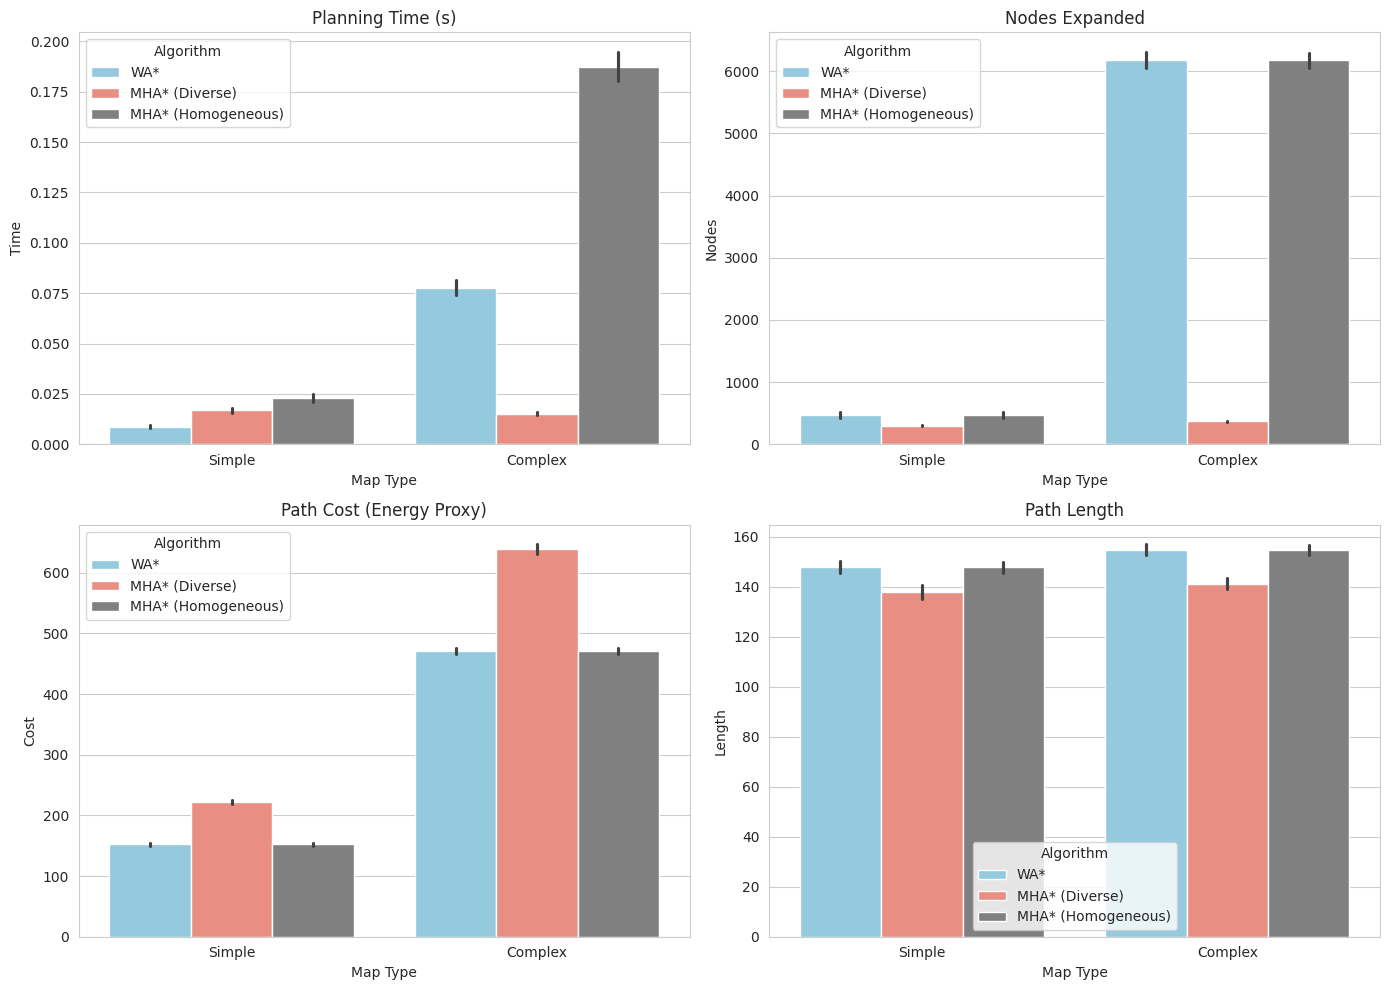

In [3]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

def get_effect_size(x, y):
    nx, ny = len(x), len(y)
    pool_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pool_std

def run_experiments():
    with open("mars_maps_data.pkl", "rb") as f:
        maps = pickle.load(f)

    data = []
    wins = {'WA*': 0, 'MHA* (Diverse)': 0, 'MHA* (Homogeneous)': 0}

    for m in maps:
        for start, goal in m["problems"]:

            t0 = time.time()
            p1, n1, c1 = WAStar(m["grid"], start, goal, dist_euclidean)
            dt1 = time.time() - t0

            t0 = time.time()
            p2, n2, c2 = MHAStar(m["grid"], start, goal, [dist_euclidean, dist_manhattan, dist_aggressive])
            dt2 = time.time() - t0

            t0 = time.time()
            p3, n3, c3 = MHAStar(m["grid"], start, goal, [dist_euclidean]*3)
            dt3 = time.time() - t0

            if p1 and p2 and p3:
                wins["WA*"] += 1
                wins["MHA* (Diverse)"] += 1
                wins["MHA* (Homogeneous)"] += 1

                data.extend([
                    {'Map Type': m['type'], 'Algorithm': 'WA*', 'Time': dt1, 'Nodes': n1, 'Cost': c1, 'Length': len(p1)},
                    {'Map Type': m['type'], 'Algorithm': 'MHA* (Diverse)', 'Time': dt2, 'Nodes': n2, 'Cost': c2, 'Length': len(p2)},
                    {'Map Type': m['type'], 'Algorithm': 'MHA* (Homogeneous)', 'Time': dt3, 'Nodes': n3, 'Cost': c3, 'Length': len(p3)}
                ])

    df = pd.DataFrame(data)

    print("\n=== DESCRIPTIVE STATISTICS ===")
    stats = df.groupby(['Map Type', 'Algorithm']).agg(
        mean=('Time', 'mean'), std=('Time', 'std'), median=('Time', 'median'), n=('Time', 'count')
    )
    stats['95% CI'] = 1.96 * stats['std'] / np.sqrt(stats['n'])
    print(stats)

    print("\n=== WELCH T-TESTS (TIME) ===")
    for mtype in ['Simple', 'Complex']:
        a = df[(df['Map Type'] == mtype) & (df['Algorithm'] == 'WA*')]['Time']
        b = df[(df['Map Type'] == mtype) & (df['Algorithm'] == 'MHA* (Diverse)')]['Time']
        t, p = ttest_ind(a, b, equal_var=False)
        d = get_effect_size(a, b)
        print(f"{mtype}: WA* vs MHA*(Diverse) | p={p:.2e}, d={d:.2f}")

    print("\n=== SUCCESS COUNTS ===")
    print(wins)

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    pal = {'WA*': 'skyblue', 'MHA* (Diverse)': 'salmon', 'MHA* (Homogeneous)': 'gray'}

    sns.barplot(data=df, x='Map Type', y='Time', hue='Algorithm', ax=axes[0,0], palette=pal, ci=95)
    axes[0,0].set_title("Planning Time (s)")

    sns.barplot(data=df, x='Map Type', y='Nodes', hue='Algorithm', ax=axes[0,1], palette=pal, ci=95)
    axes[0,1].set_title("Nodes Expanded")

    sns.barplot(data=df, x='Map Type', y='Cost', hue='Algorithm', ax=axes[1,0], palette=pal, ci=95)
    axes[1,0].set_title("Path Cost (Energy Proxy)")

    sns.barplot(data=df, x='Map Type', y='Length', hue='Algorithm', ax=axes[1,1], palette=pal, ci=95)
    axes[1,1].set_title("Path Length")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiments()

Visualizing results on Map #8 (Complex type)...


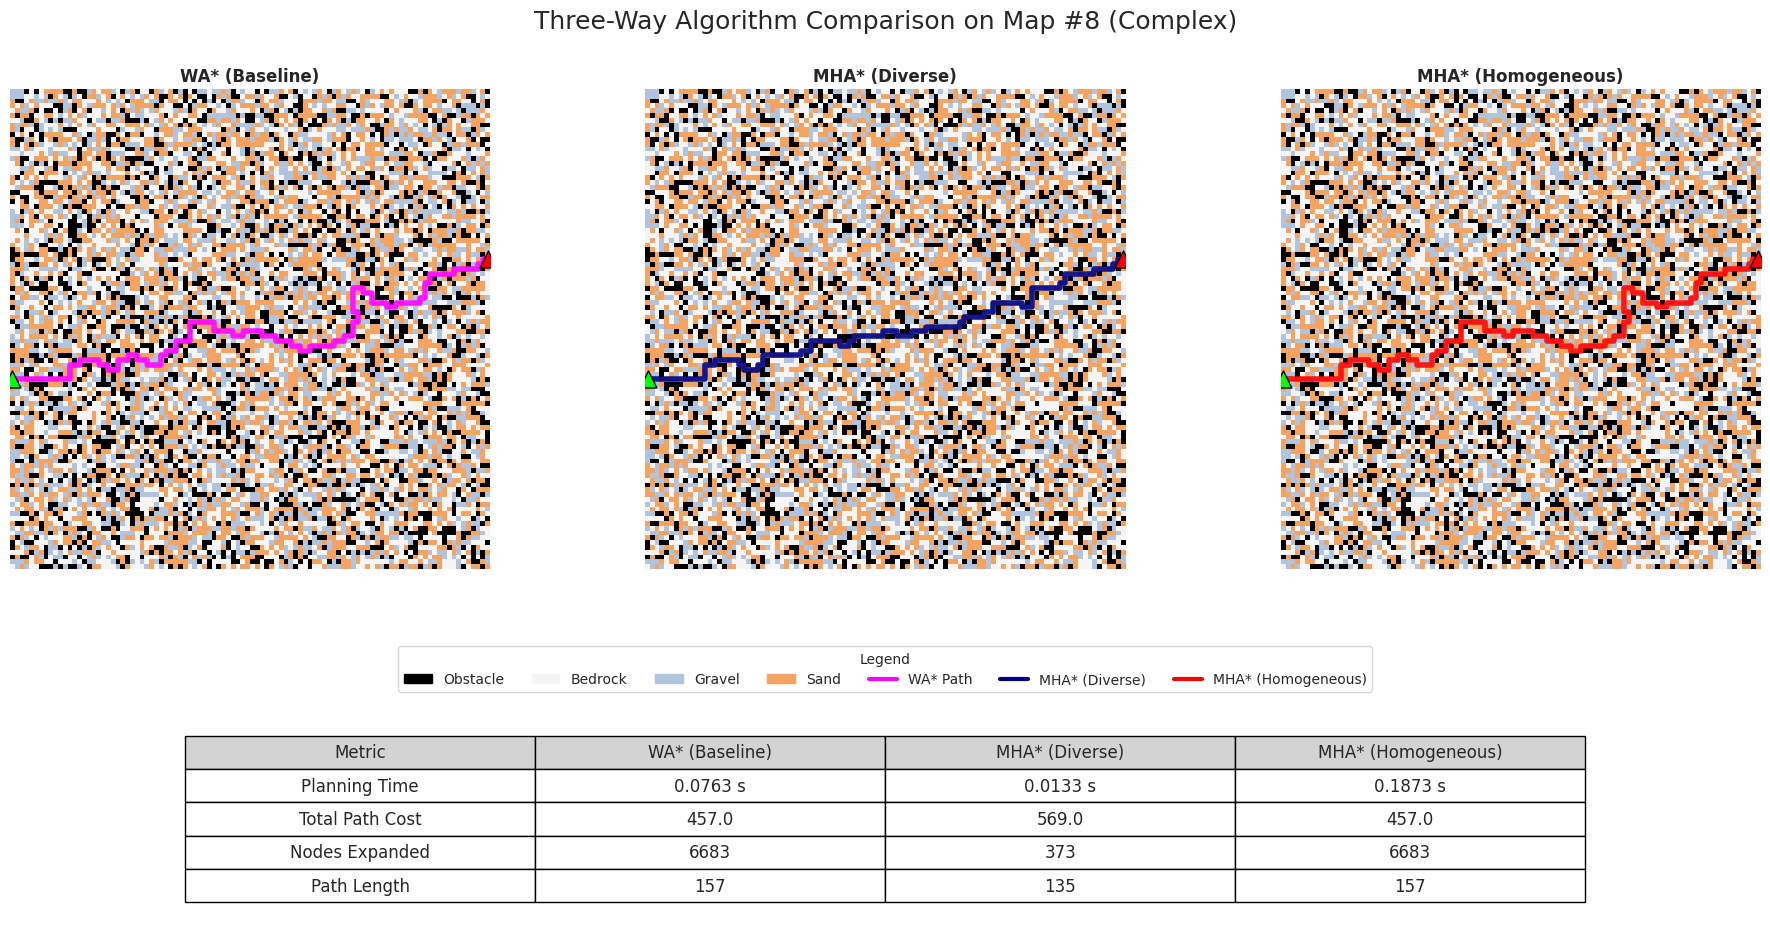

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import pickle
import random
import time
from matplotlib.lines import Line2D

def visualize_results():
    try:
        with open("mars_maps_data.pkl", 'rb') as f:
            maps = pickle.load(f)
    except:
        print("Data file not found.")
        return

    complex_maps = [m for m in maps if m['type'] == 'Complex']
    if not complex_maps: return

    sel = random.choice(complex_maps)
    grid = sel['grid']
    start, goal = random.choice(sel['problems'])
    mid = sel['map_id']

    print(f"Visualizing results on Map #{mid} (Complex type)...")

    t0 = time.time()
    p1, n1, c1 = WAStar(grid, start, goal, dist_euclidean, eps=1.5)
    t1 = time.time() - t0
    l1 = len(p1) if p1 else 0

    t0 = time.time()
    p2, n2, c2 = MHAStar(grid, start, goal, [dist_euclidean, dist_manhattan, dist_aggressive], w1=1.5, w2=1.5)
    t2 = time.time() - t0
    l2 = len(p2) if p2 else 0

    t0 = time.time()
    p3, n3, c3 = MHAStar(grid, start, goal, [dist_euclidean]*3, w1=1.5, w2=1.5)
    t3 = time.time() - t0
    l3 = len(p3) if p3 else 0

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    plt.subplots_adjust(bottom=0.4, left=0.05, right=0.95)

    cmap = colors.ListedColormap(['black', 'whitesmoke', 'lightsteelblue', 'sandybrown'])
    bounds = [-0.5, 0.5, 2.5, 7.5, 12.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    def draw(ax, title, path, col):
        ax.imshow(grid, cmap=cmap, norm=norm, origin='upper')
        ax.scatter(start[1], start[0], marker='^', s=150, c='lime', edgecolors='k', zorder=5)
        ax.scatter(goal[1], goal[0], marker='^', s=150, c='red', edgecolors='k', zorder=5)
        if path:
            ys, xs = zip(*path)
            ax.plot(xs, ys, color=col, lw=4, alpha=0.9)
        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.axis('off')

    draw(ax1, "WA* (Baseline)", p1, 'magenta')
    draw(ax2, "MHA* (Diverse)", p2, 'navy')
    draw(ax3, "MHA* (Homogeneous)", p3, 'red')

    plt.suptitle(f"Three-Way Algorithm Comparison on Map #{mid} (Complex)", fontsize=18, y=0.96)

    legs = [
        mpatches.Patch(color='black', label='Obstacle'),
        mpatches.Patch(color='whitesmoke', label='Bedrock'),
        mpatches.Patch(color='lightsteelblue', label='Gravel'),
        mpatches.Patch(color='sandybrown', label='Sand'),
        Line2D([0], [0], color='magenta', lw=3, label='WA* Path'),
        Line2D([0], [0], color='navy', lw=3, label='MHA* (Diverse)'),
        Line2D([0], [0], color='red', lw=3, label='MHA* (Homogeneous)')
    ]
    fig.legend(handles=legs, loc='center', bbox_to_anchor=(0.5, 0.30), ncol=7, title="Legend")

    rows = [
        ['Planning Time', f"{t1:.4f} s", f"{t2:.4f} s", f"{t3:.4f} s"],
        ['Total Path Cost', f"{c1:.1f}", f"{c2:.1f}", f"{c3:.1f}"],
        ['Nodes Expanded', f"{n1}", f"{n2}", f"{n3}"],
        ['Path Length', f"{l1}", f"{l2}", f"{l3}"]
    ]
    cols = ['Metric', 'WA* (Baseline)', 'MHA* (Diverse)', 'MHA* (Homogeneous)']

    tax = fig.add_axes([0.15, 0.05, 0.7, 0.2])
    tax.axis('off')
    tbl = tax.table(cellText=rows, colLabels=cols, loc='center', cellLoc='center')
    tbl.scale(1, 2)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)

    for (r, c), cell in tbl.get_celld().items():
        if r == 0: cell.set_facecolor('lightgrey')

    plt.show()

if __name__ == "__main__":
    visualize_results()